<a href="https://colab.research.google.com/github/zhibinz2/Neural-Networks-and-Machine-Learning/blob/master/%E2%80%9C%E2%80%9CZHIBIN_Final_Project_Leave_One_Out_8_nin_nist_ipynb%E2%80%9D20201209office_hour_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
!wget https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/data.npy
data=np.load('data.npy')

import tqdm

import torch
from torch import optim
from torch import nn


import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision import models, transforms
from torch.autograd import Variable

import pandas as pd
from PIL import Image
import requests
import io
import random, time, sys
from collections import namedtuple

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

--2020-12-11 06:32:22--  https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/data.npy
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zhibinz2/Neural-Networks-and-Machine-Learning/master/data.npy [following]
--2020-12-11 06:32:22--  https://raw.githubusercontent.com/zhibinz2/Neural-Networks-and-Machine-Learning/master/data.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11262288 (11M) [application/octet-stream]
Saving to: ‘data.npy’

data.npy            100%[===================>]  10.74M  --.-KB/s    in 0.08s   

2020-12-11 06:32:22 (140 MB/s) - ‘data.npy’ saved [11262288/

In [2]:
# resize the data to 28 by 28 (only for convolutional network)
import cv2
# resize matrices into 28 by 28 (for convolutional network only)
resize=np.zeros([170,28,28])
for j in np.array(range(170)):
    img=data[j,:,:]
    dim = (28, 28)
    resize[j,:,:] = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
data=resize

In [3]:
# Add one dimension, needed for both single layer FCN and convolutional network
data=np.expand_dims(data, axis=1)

In [4]:
# Creat the targets (Only for convolutional network)
A=np.zeros(110)
B=np.ones(60)
targets=np.concatenate((A,B),axis=0)

In [5]:
# leave one out
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

In [6]:
from torch.utils.data import Dataset
class MyTrainingDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.root=root
        self.transform=transform
        self.target_transform=target_transform
        self.data=np.load(self.root[0])
        self.targets=np.load(self.root[1])
        
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        sample=self.data[idx] 
        target=self.targets[idx]
        
        if self.transform:
            sample=self.transform(sample)
        if self.target_transform:
            target=self.target_transform(target)
            
        return sample, target

In [7]:
class NIN(torch.nn.Module):
    def __init__(self):
        super(NIN, self).__init__()

        self.nin1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3, stride=2),
            torch.nn.Dropout(.5)          
        )
        self.nin2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3, stride=2),
            torch.nn.Dropout(.5)          
        )
        self.nin3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 2, 1),
            torch.nn.ReLU(),
        )
        self.pool = torch.nn.AvgPool2d(6, stride=1)  


    def forward(self, x):
        x = self.nin1(x)
        x = self.nin2(x)
        x = self.nin3(x)
        x = self.pool(x)
        return x.view(-1,2)

net = NIN().cuda()

In [8]:
mse_loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

In [9]:
def train_step(x, t, net, opt_fn, loss_fn):
    y = net(x.cuda())
    loss = loss_fn(y, t.cuda())
    loss.backward()
    opt_fn.step()
    opt_fn.zero_grad()
    return loss

In [ ]:
acc_hist_train = []
acc_hist_test = []

for train_index, test_index in loo.split(data):
  #print("TRAIN:", train_index, "TEST:", test_index)
  train_data, test_data = data[train_index], data[test_index]
  train_targets, test_targets = targets[train_index], targets[test_index]
  #print(train_data, test_data, train_targets, test_targets)

  np.save('train_data.npy',train_data)
  np.save('train_targets.npy',train_targets)
  train_set=MyTrainingDataset(root=['train_data.npy', 'train_targets.npy'])

  np.save('test_data.npy',test_data)
  np.save('test_targets.npy',test_targets)
  test_set=MyTrainingDataset(root=['test_data.npy', 'test_targets.npy'])

  net = NIN().cuda()
  mse_loss = torch.nn.CrossEntropyLoss()
  opt = torch.optim.Adam(net.parameters(), lr=1e-3)

  batch=100
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch, shuffle=False)

  # 8_nin_nist
  x, t = next(iter(train_loader))
  net(x.float().cuda()).shape

  net = NIN().cuda()
  mse_loss = torch.nn.CrossEntropyLoss()
  opt = torch.optim.Adam(net.parameters(), lr=1e-3)

  x,t = next(iter(train_loader))

  train_step(x.float(), t.long(), net, opt, mse_loss)
  
  # Train the network over multiple epochs

  for epoch in range(50):
    acc_batch = []
    net.train()
    for x,t in iter(train_loader):   
        loss_train = train_step(x.float(), t.long(), net, opt, mse_loss)
        y = net(x.float().cuda()).cpu()
        acc_batch.append(torch.mean((t == y.argmax(1)).float()))
    acc_hist_train.append(torch.mean(torch.FloatTensor(acc_batch)))   
    print(loss_train)

    net.eval()
    acc_batch = []
    for x,t in iter(test_loader):   
        y = net(x.float().cuda()).cpu()
        acc_batch.append(torch.mean((t == y.argmax(1)).float()))
    acc_hist_test.append(torch.mean(torch.FloatTensor(acc_batch))) 





In [ ]:
acc_hist_train

In [ ]:
acc_hist_test

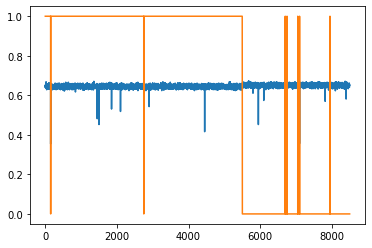

In [18]:
import pylab as plt
plt.plot(range(len(acc_hist_train)), acc_hist_train)
plt.plot(range(len(acc_hist_test)), acc_hist_test)

In [19]:
Test_accuracy=np.mean(acc_hist_test)
Test_accuracy

0.64741176